In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import  classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline 

In [9]:
import importlib
import ids_common
importlib.reload(ids_common)

<module 'ids_common' from 'd:\\stuff\\univ\\ids\\ids_common.py'>

In [10]:
SEED = random.randint(0, 42424242)
SEED = 42
print(f'SEED = {SEED}')

SEED = 42


In [15]:
df_orig = pd.read_csv('./sampled_data/sample_1/clean_ml_sample.csv', low_memory=False)

In [16]:
df_orig['Attack_type'].value_counts()

Attack_type
Normal                   10000
DDoS_UDP                 10000
Password                 10000
XSS                      10000
DDoS_ICMP                10000
DDoS_TCP                 10000
SQL_injection            10000
Uploading                10000
DDoS_HTTP                10000
Backdoor                 10000
Port_Scanning            10000
Vulnerability_scanner    10000
Ransomware                9141
OS_Fingerprinting          724
MITM                       358
Name: count, dtype: int64

In [17]:
# df = pd.DataFrame()

# for atype in df_orig['Attack_type'].unique():
#     tmp = df_orig[df_orig['Attack_type']== atype]
#     df = pd.concat([df, tmp.sample(n=min(10000, tmp.shape[0]))], ignore_index=True)

# df['Attack_type'].value_counts()

In [14]:
# sample_dir = './sampled_data/sample_1/'
# df.to_csv(sample_dir + 'clean_ml_sample.csv', index=False)

In [18]:
df_train, df_test = ids_common.ds_split(df_orig, seed=42)
print(f'df_train={df_train.shape}')
print(f'df_test={df_test.shape}')

X_train, y_train = ids_common.get_X_y(df_train, ids_common.target_label_2_class)
print(f'X_train={X_train.shape} y_train={y_train.shape}')

X_test, y_test = ids_common.get_X_y(df_test, ids_common.target_label_2_class)
print(f'X_test={X_test.shape} y_test={y_test.shape}')

df_train=(104178, 61)
df_test=(26045, 61)
X_train=(104178, 59) y_train=(104178,)
X_test=(26045, 59) y_test=(26045,)


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

models = [
    DecisionTreeClassifier(
        **{'criterion': 'entropy', 'max_depth': 16}, random_state=SEED),
    RandomForestClassifier(
        **{'criterion': 'entropy', 'max_depth': 128, 'max_features': 'log2', 'n_estimators': 100},random_state=SEED),
    LogisticRegression(
        **{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}, max_iter=10000, random_state=SEED),
    KNeighborsClassifier(5),
    QuadraticDiscriminantAnalysis(),
    AdaBoostClassifier(algorithm="SAMME", random_state=SEED),
    xgb.XGBClassifier(objective="binary:logistic", random_state=SEED)

]

DecisionTreeClassifier:
Train score: 0.9871278004953061
Test score:  0.9875599923209829
TRAIN:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      8000
           1       0.99      1.00      0.99     96178

    accuracy                           0.99    104178
   macro avg       0.99      0.92      0.95    104178
weighted avg       0.99      0.99      0.99    104178

TEST:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2000
           1       0.99      1.00      0.99     24045

    accuracy                           0.99     26045
   macro avg       0.99      0.92      0.95     26045
weighted avg       0.99      0.99      0.99     26045



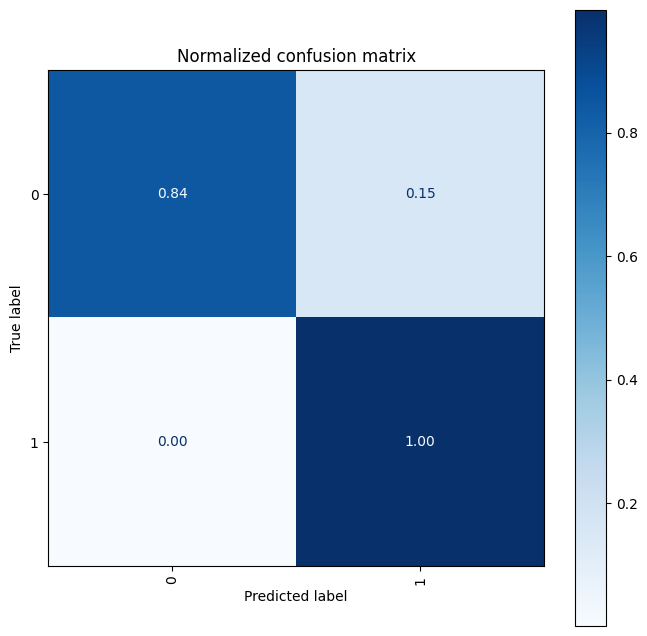

################################################################################
RandomForestClassifier:
Train score: 1.0
Test score:  0.9855250527932424
TRAIN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8000
           1       1.00      1.00      1.00     96178

    accuracy                           1.00    104178
   macro avg       1.00      1.00      1.00    104178
weighted avg       1.00      1.00      1.00    104178

TEST:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      2000
           1       0.99      1.00      0.99     24045

    accuracy                           0.99     26045
   macro avg       0.97      0.93      0.95     26045
weighted avg       0.99      0.99      0.99     26045



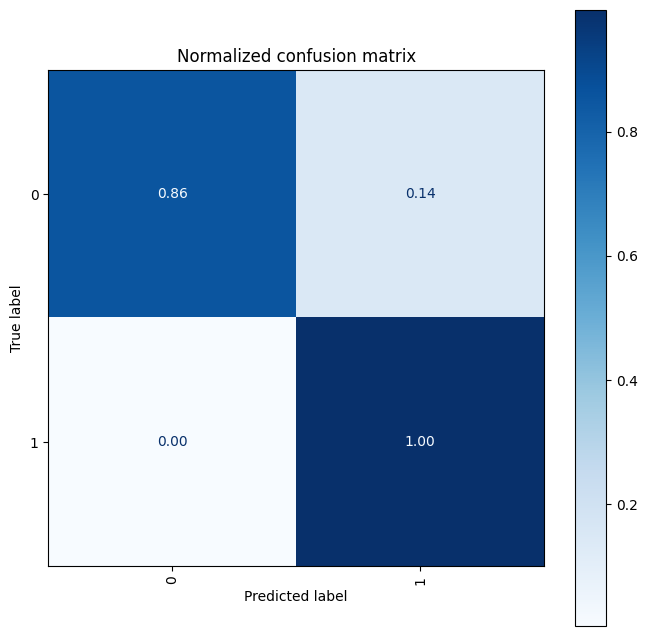

################################################################################
LogisticRegression:
Train score: 0.9260208489316363
Test score:  0.9262814359761951
TRAIN:
              precision    recall  f1-score   support

           0       1.00      0.04      0.07      8000
           1       0.93      1.00      0.96     96178

    accuracy                           0.93    104178
   macro avg       0.96      0.52      0.52    104178
weighted avg       0.93      0.93      0.89    104178

TEST:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08      2000
           1       0.93      1.00      0.96     24045

    accuracy                           0.93     26045
   macro avg       0.96      0.52      0.52     26045
weighted avg       0.93      0.93      0.89     26045



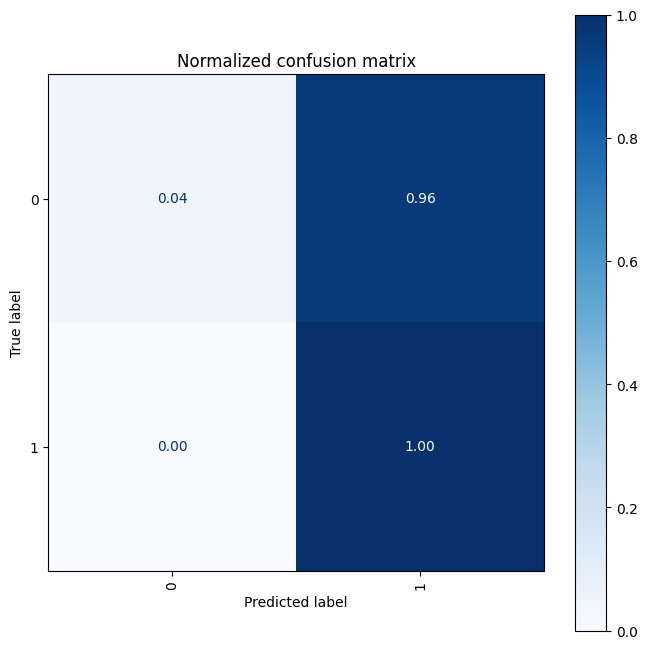

################################################################################
KNeighborsClassifier:
Train score: 0.932154581581524
Test score:  0.9228258782875792
TRAIN:
              precision    recall  f1-score   support

           0       0.72      0.19      0.30      8000
           1       0.94      0.99      0.96     96178

    accuracy                           0.93    104178
   macro avg       0.83      0.59      0.63    104178
weighted avg       0.92      0.93      0.91    104178

TEST:
              precision    recall  f1-score   support

           0       0.49      0.12      0.19      2000
           1       0.93      0.99      0.96     24045

    accuracy                           0.92     26045
   macro avg       0.71      0.55      0.58     26045
weighted avg       0.90      0.92      0.90     26045



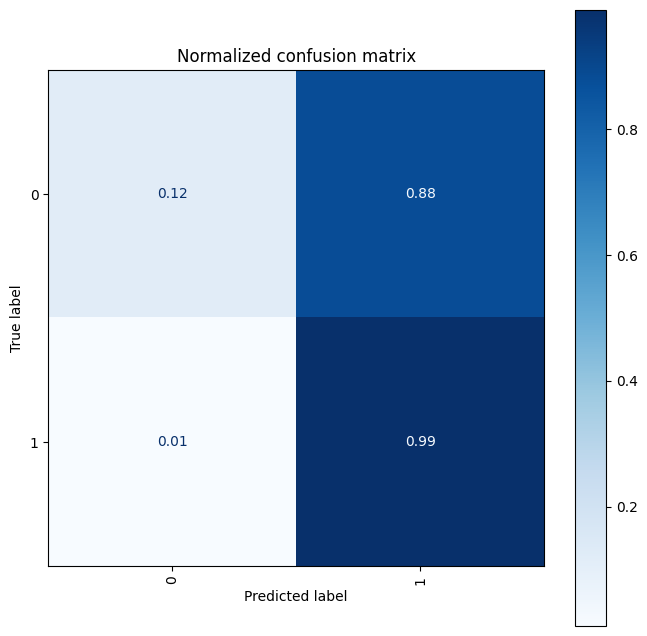

################################################################################


c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis:
Train score: 0.9488663633396687
Test score:  0.9485889806104819
TRAIN:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50      8000
           1       0.95      1.00      0.97     96178

    accuracy                           0.95    104178
   macro avg       0.97      0.67      0.74    104178
weighted avg       0.95      0.95      0.94    104178

TEST:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50      2000
           1       0.95      1.00      0.97     24045

    accuracy                           0.95     26045
   macro avg       0.97      0.67      0.73     26045
weighted avg       0.95      0.95      0.94     26045



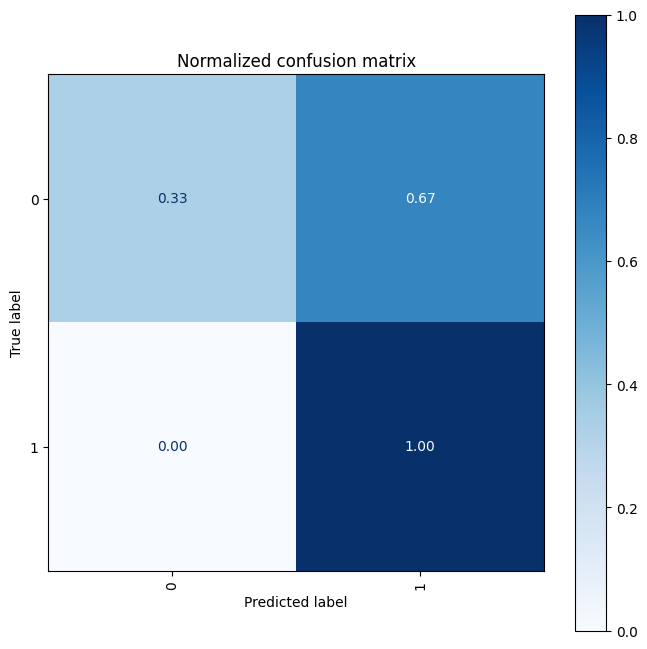

################################################################################
AdaBoostClassifier:
Train score: 0.9799573806369867
Test score:  0.9807640622000384
TRAIN:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      8000
           1       0.98      1.00      0.99     96178

    accuracy                           0.98    104178
   macro avg       0.98      0.87      0.92    104178
weighted avg       0.98      0.98      0.98    104178

TEST:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      2000
           1       0.98      1.00      0.99     24045

    accuracy                           0.98     26045
   macro avg       0.98      0.88      0.92     26045
weighted avg       0.98      0.98      0.98     26045



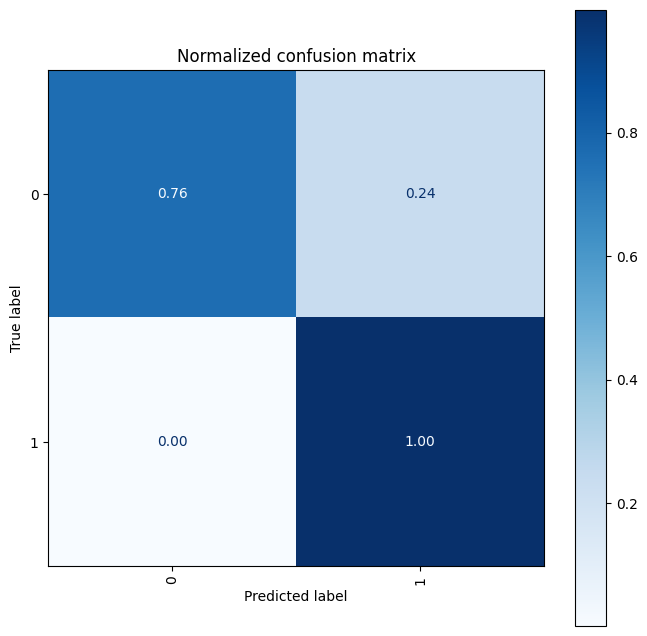

################################################################################
XGBClassifier:
Train score: 0.9873005816967114
Test score:  0.9873296218084086
TRAIN:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      8000
           1       0.99      1.00      0.99     96178

    accuracy                           0.99    104178
   macro avg       0.99      0.92      0.95    104178
weighted avg       0.99      0.99      0.99    104178

TEST:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2000
           1       0.99      1.00      0.99     24045

    accuracy                           0.99     26045
   macro avg       0.99      0.92      0.95     26045
weighted avg       0.99      0.99      0.99     26045



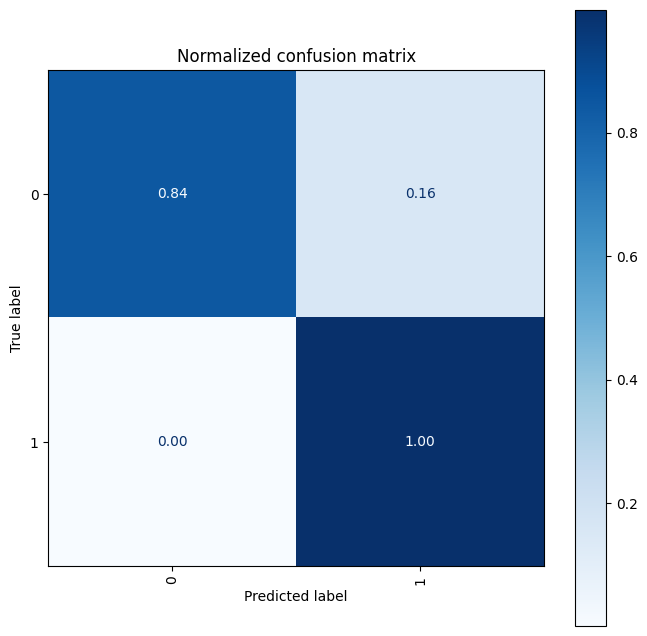

################################################################################


In [20]:
for cls in models:
    cls.fit(X_train, y_train)

    y_train_predict = cls.predict(X_train)
    y_test_predict = cls.predict(X_test)

    print(f'{cls.__class__.__name__}:')
    print(f'Train score: {cls.score(X_train, y_train)}')
    print(f'Test score:  {cls.score(X_test, y_test)}')

    ids_common.report(y_train, y_train_predict, y_test, y_test_predict)
    ids_common.plot_cm(y_test, y_test_predict)

    print('#'*80)

TRAIN:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1380608
           1       0.99      0.98      0.99    812684

    accuracy                           0.99   2193292
   macro avg       0.99      0.99      0.99   2193292
weighted avg       0.99      0.99      0.99   2193292

TEST:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    345153
           1       0.92      0.92      0.92    203171

    accuracy                           0.94    548324
   macro avg       0.93      0.93      0.93    548324
weighted avg       0.94      0.94      0.94    548324



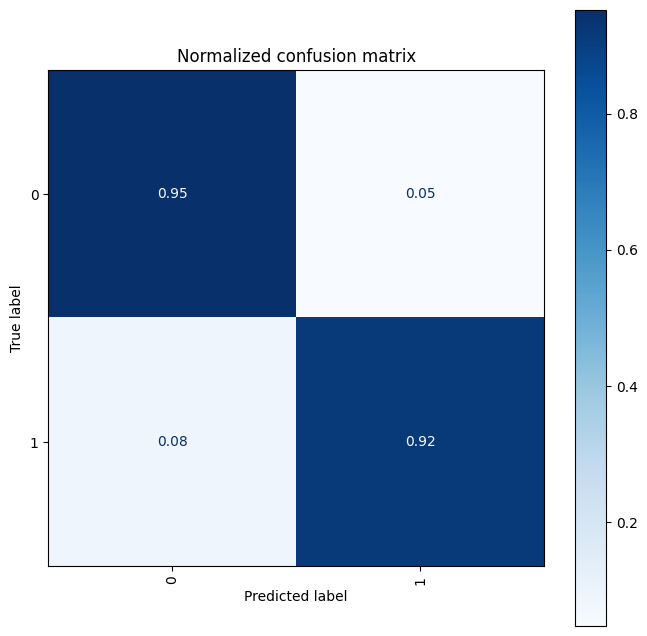

In [11]:
# basic

detector = DecisionTreeClassifier(random_state=SEED)

detector.fit(X_train_detection, y_train_detection)
y_train_detection_predict = detector.predict(X_train_detection)
y_test_detection_predict = detector.predict(X_test_detection)

ids_common.report(y_train_detection, 
       y_train_detection_predict, 
       y_test_detection,
       y_test_detection_predict)

ids_common.plot_cm(y_test_detection, y_test_detection_predict)

TRAIN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1380609
           1       1.00      1.00      1.00    775513

    accuracy                           1.00   2156122
   macro avg       1.00      1.00      1.00   2156122
weighted avg       1.00      1.00      1.00   2156122

TEST:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    345152
           1       0.94      0.95      0.95    193879

    accuracy                           0.96    539031
   macro avg       0.96      0.96      0.96    539031
weighted avg       0.96      0.96      0.96    539031



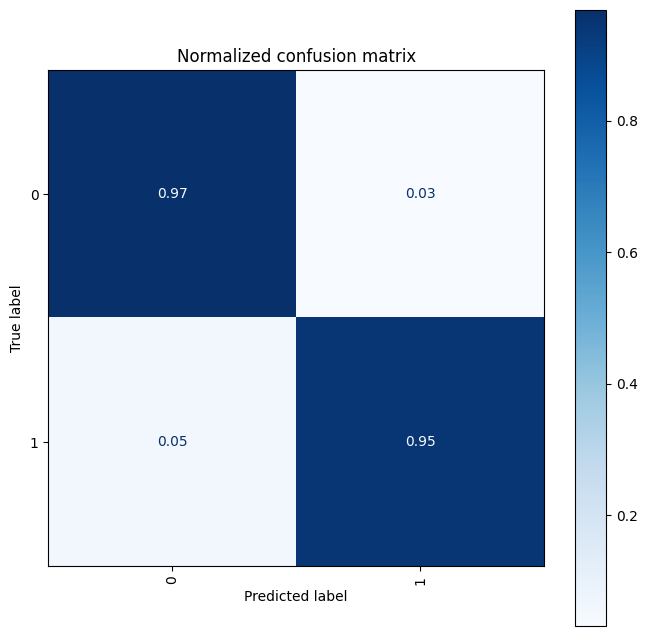

In [28]:
# with additional duplication drop

detector = DecisionTreeClassifier(random_state=SEED)

detector.fit(X_train_detection, y_train_detection)
y_train_detection_predict = detector.predict(X_train_detection)
y_test_detection_predict = detector.predict(X_test_detection)

ids_common.report(y_train_detection, 
       y_train_detection_predict, 
       y_test_detection,
       y_test_detection_predict)

ids_common.plot_cm(y_test_detection, y_test_detection_predict)

TRAIN:
                       precision    recall  f1-score   support

             Backdoor       0.98      1.00      0.99     15377
            DDoS_HTTP       0.92      1.00      0.96     68999
            DDoS_ICMP       1.00      1.00      1.00     63786
             DDoS_TCP       1.00      1.00      1.00    129278
             DDoS_UDP       1.00      1.00      1.00    204893
                 MITM       1.00      1.00      1.00       230
    OS_Fingerprinting       0.94      0.95      0.95       546
             Password       0.99      0.98      0.99    198266
        Port_Scanning       1.00      1.00      1.00     12785
           Ransomware       1.00      0.98      0.99      6201
        SQL_injection       0.99      0.97      0.98     32529
            Uploading       1.00      0.91      0.95     23556
Vulnerability_scanner       1.00      1.00      1.00     46596
                  XSS       1.00      0.96      0.98      9642

             accuracy                         

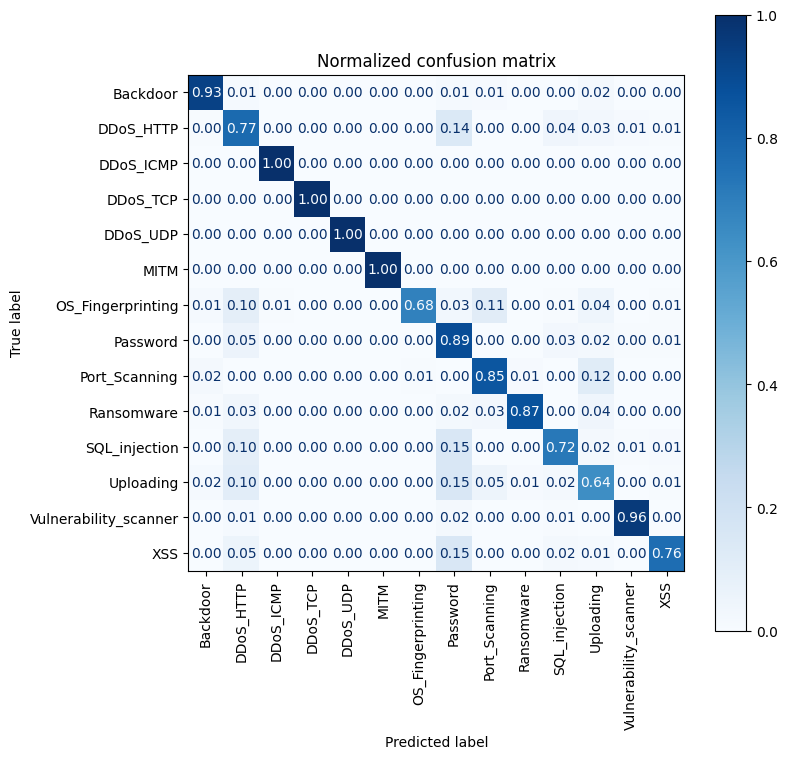

In [12]:
classifier = DecisionTreeClassifier(random_state=SEED)

classifier.fit(X_train_classification, y_train_classification)
y_train_classification_predict = classifier.predict(X_train_classification)
y_test_classification_predict = classifier.predict(X_test_classification)

ids_common.report(y_train_classification, 
       y_train_classification_predict, 
       y_test_classification,
       y_test_classification_predict)

ids_common.plot_cm(y_test_classification, y_test_classification_predict)

TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      1.00      1.00     14887
            DDoS_HTTP       1.00      1.00      1.00     54395
            DDoS_ICMP       1.00      1.00      1.00     63784
             DDoS_TCP       1.00      1.00      1.00    129276
             DDoS_UDP       1.00      1.00      1.00    204892
                 MITM       1.00      1.00      1.00       229
    OS_Fingerprinting       1.00      1.00      1.00       466
             Password       1.00      1.00      1.00    184493
        Port_Scanning       1.00      1.00      1.00     12783
           Ransomware       1.00      1.00      1.00      5864
        SQL_injection       1.00      1.00      1.00     30084
            Uploading       1.00      1.00      1.00     19277
Vulnerability_scanner       1.00      1.00      1.00     46167
                  XSS       1.00      1.00      1.00      8916

             accuracy                         

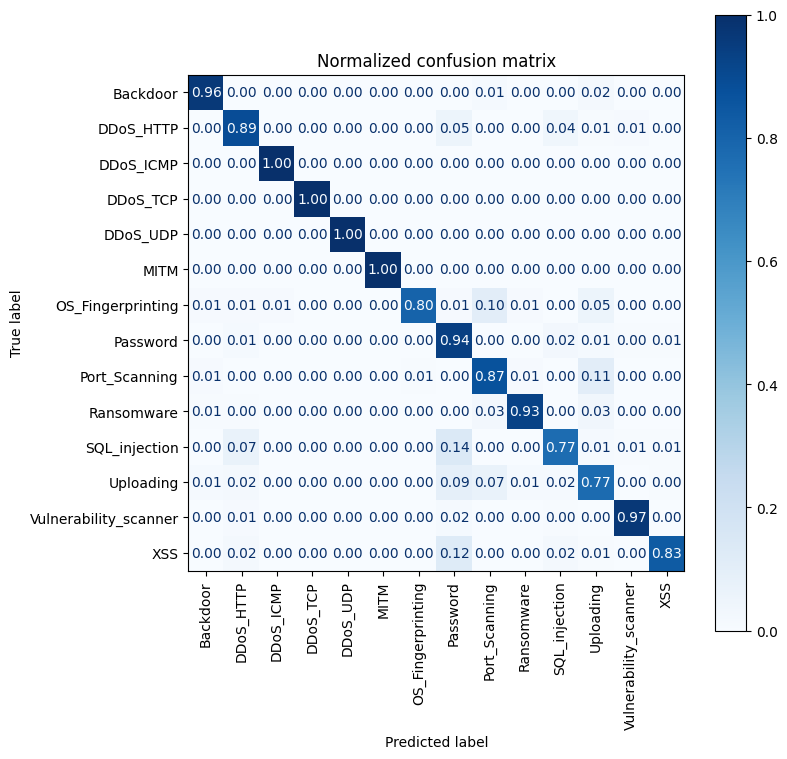

In [29]:
classifier = DecisionTreeClassifier(random_state=SEED)

classifier.fit(X_train_classification, y_train_classification)
y_train_classification_predict = classifier.predict(X_train_classification)
y_test_classification_predict = classifier.predict(X_test_classification)

ids_common.report(y_train_classification, 
       y_train_classification_predict, 
       y_test_classification,
       y_test_classification_predict)

ids_common.plot_cm(y_test_classification, y_test_classification_predict)

DETECTION:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    431440
           1       0.92      0.92      0.92    253964

    accuracy                           0.94    685404
   macro avg       0.94      0.93      0.93    685404
weighted avg       0.94      0.94      0.94    685404



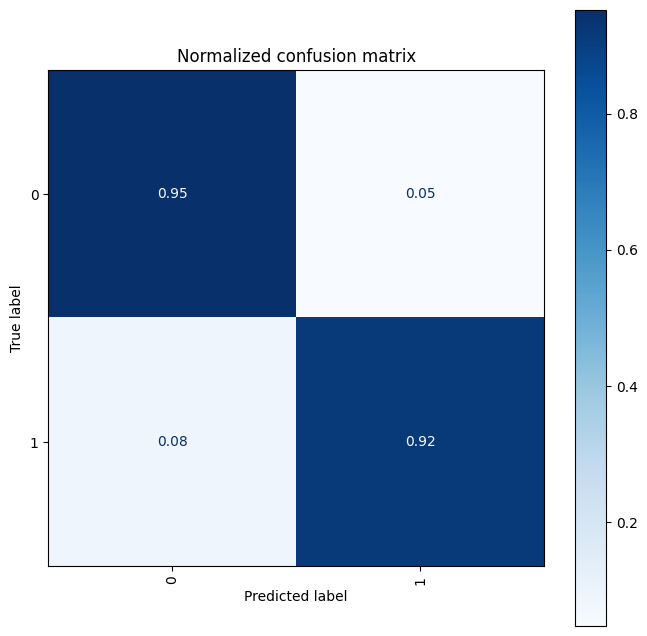

CLASSIFICATION:
                       precision    recall  f1-score   support

             Backdoor       0.92      0.93      0.93      4805
            DDoS_HTTP       0.69      0.71      0.70     21562
            DDoS_ICMP       1.00      1.00      1.00     19933
             DDoS_TCP       1.00      1.00      1.00     40399
             DDoS_UDP       1.00      1.00      1.00     64029
                 MITM       1.00      1.00      1.00        72
               Normal       0.95      0.95      0.95    431440
    OS_Fingerprinting       0.69      0.66      0.68       171
             Password       0.78      0.77      0.78     61958
        Port_Scanning       0.87      0.86      0.87      3996
           Ransomware       0.90      0.89      0.89      1938
        SQL_injection       0.70      0.69      0.70     10165
            Uploading       0.67      0.63      0.65      7362
Vulnerability_scanner       0.96      0.96      0.96     14561
                  XSS       0.78      

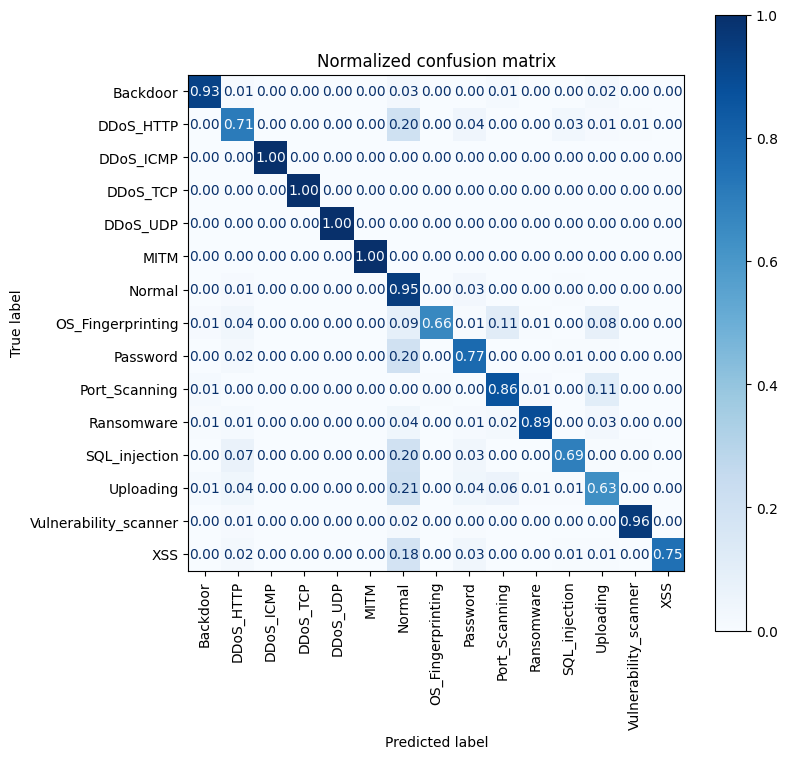

In [14]:
y_global_label = df_test_global[target_label_2_class]
y_global_type = df_test_global[target_label_15_class]
X_global = df_test_global.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)


y_global_detection_predict = detector.predict(X_global)

ds_classification = df_test_global[y_global_detection_predict==1]
X_global_classification = ds_classification.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

y_global_classification_predict = classifier.predict(X_global_classification)


global_result = pd.Series(y_global_detection_predict, index=X_global.index.copy())
global_result = global_result.map(lambda x: 'Normal' if x==0 else 'Attack')
global_result.loc[X_global_classification.index] = y_global_classification_predict

print('DETECTION:')
print(classification_report(y_global_label, y_global_detection_predict))
ids_common.plot_cm(y_global_label, y_global_detection_predict)

print('CLASSIFICATION:')
print(classification_report(y_global_type, global_result))
ids_common.plot_cm(y_global_type, global_result)

DETECTION:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    431440
           1       0.94      0.95      0.95    242349

    accuracy                           0.96    673789
   macro avg       0.96      0.96      0.96    673789
weighted avg       0.96      0.96      0.96    673789



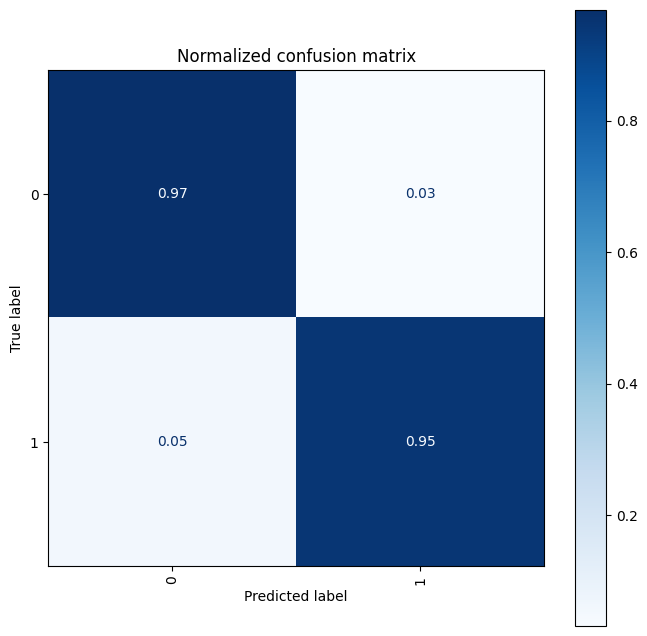

CLASSIFICATION:
                       precision    recall  f1-score   support

             Backdoor       0.96      0.97      0.96      4652
            DDoS_HTTP       0.88      0.88      0.88     16998
            DDoS_ICMP       1.00      1.00      1.00     19933
             DDoS_TCP       1.00      1.00      1.00     40399
             DDoS_UDP       1.00      1.00      1.00     64029
                 MITM       0.99      1.00      0.99        72
               Normal       0.97      0.97      0.97    431440
    OS_Fingerprinting       0.78      0.84      0.81       146
             Password       0.83      0.83      0.83     57654
        Port_Scanning       0.87      0.86      0.86      3995
           Ransomware       0.93      0.93      0.93      1833
        SQL_injection       0.74      0.75      0.74      9401
            Uploading       0.75      0.76      0.76      6024
Vulnerability_scanner       0.96      0.97      0.97     14427
                  XSS       0.80      

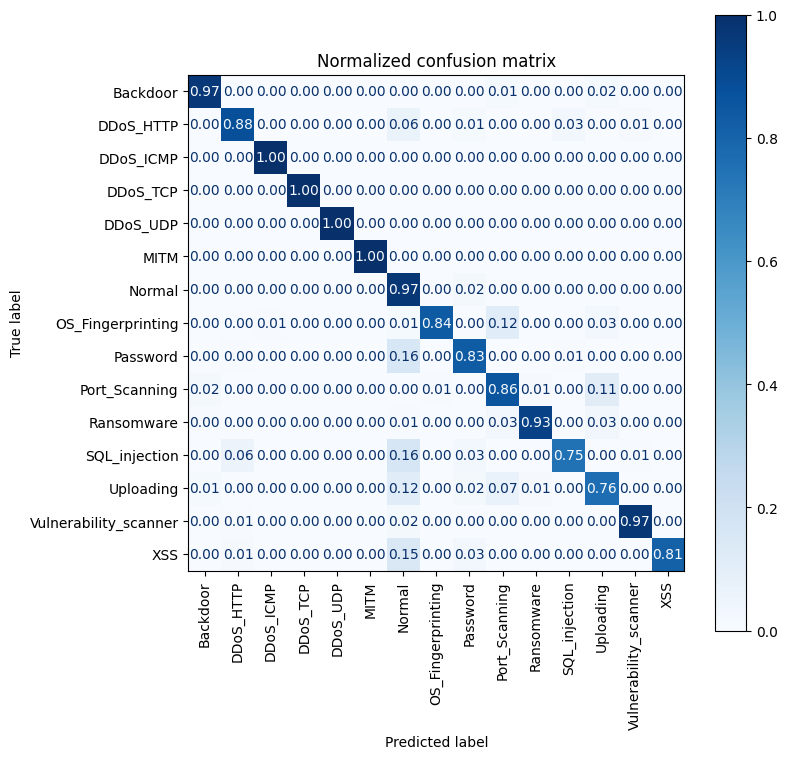

In [30]:
y_global_label = df_test_global[target_label_2_class]
y_global_type = df_test_global[target_label_15_class]
X_global = df_test_global.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)


y_global_detection_predict = detector.predict(X_global)

ds_classification = df_test_global[y_global_detection_predict==1]
X_global_classification = ds_classification.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

y_global_classification_predict = classifier.predict(X_global_classification)


global_result = pd.Series(y_global_detection_predict, index=X_global.index.copy())
global_result = global_result.map(lambda x: 'Normal' if x==0 else 'Attack')
global_result.loc[X_global_classification.index] = y_global_classification_predict

print('DETECTION:')
print(classification_report(y_global_label, y_global_detection_predict))
ids_common.plot_cm(y_global_label, y_global_detection_predict)

print('CLASSIFICATION:')
print(classification_report(y_global_type, global_result))
ids_common.plot_cm(y_global_type, global_result)